(eigenvals)=

# Проблема собственных значений

Автор(ы):

- [Синченко Семен](https://github.com/SemyonSinchenko)


## Введение

Мы с вами узнали, что задачи комбинаторной оптимизации и квантовой химии могут быть сведены к решению проблемы поиска минимального собственного значения большого эрмитова оператора -- гамильтониана. Для оптимизационных задач это [осуществляется](../../problems2qml/ru/np2ising.md) при помощи сведения к _QUBO_-матрице и гамильтониану типа Изинга. А для электронных орбиталей из квантовой химии можно [применить](../../problems2qml/ru/jordanwigner.md) преобразование Жордана-Вигнера и также перейти к спиновому гамильтониану.

Теперь перед нами встает вопрос, а как же искать основное состояние этого гамильтониана? В этой лекции рассмотрим **классические** методы решения этой проблемы, то есть без квантовых компьютеров. Рассмотрение этих методов и их недостатков покажет то, зачем тут так нужен будет квантовый компьютер.

## О проблеме (повторение)

Эта тема обсуждалась во вводных лекциях по линейной алгебре, в [части про собственные вектора и собственные значения](../../linalg/ru/matrices.html#id9).

Итак, пусть у имеется диагонализируемая матрица $A$ размерности $n \times n$, она же является линейным оператором $\hat{A}$. Из линейной алгебры знаем, что у этой матрицы есть $n$ таких чисел $e_i$ и векторов $\Psi_i$, что для них выполняется условие:

$$
A \Psi_i = e_i \Psi_i
$$

или в нотации Дирака, которая используется в области квантовых вычислений:

$$
\hat{A} \ket{\Psi_i} = e_i\ket{\Psi_i}
$$

Таким образом, собственные вектора -- это такие вектора, которые при применении оператора не меняют свое направление. Например, в примере ниже собственный вектор -- это ось симметрии оператора:

```{figure} /_static/problems2qml/ru/eigenvals/Mona_Lisa.png
:width: 450px
:name: Mona_Lisa_Eigen

Синий вектор, в отличии от красного, при применении оператора не меняет направление так как является его собственным вектором.
```

## Итеративные алгоритмы

В целом, задача нахождения собственных значений является очень трудной с вычислительной точки зрения, особенно для больших матриц. Для матриц размера более, чем $3 \times 3$ в общем случае не существует алгоритма нахождения собственных значений и собственных векторов. Однако существует несколько итеративных алгоритмов. Рассмотрим лишь два из них, причем без особых деталей, так как эти алгоритмы, а также доказательство их сходимости являются достаточно сложными.

### Степенной метод

Один из самых простых для понимания алгоритмов, который, тем не менее находит интересные применения. Суть его в том, что берем некоторый случайный вектор $\ket{\Psi}$ и начинаем последовательно действовать на него оператором $\hat{A}$ (другими словами умножать, на нашу матрицу), при этом нормируя:

$$
\ket{\Psi_{i+1}} = \frac{\hat{A}\ket{\Psi_i}}{||\hat{A}||}
$$

И так повторяем до тех пор, пока изменение вектора не будет меньше, чем некоторое заданное маленькое значение $\epsilon$. Когда достигли этого условия, это значит что нашли первый собственный вектор, который соответствует наибольшему собственному значению. В частном случае интересных нам эрмитовых операторов, можно так же последовательно находить все собственные вектора и собственные значения.

```{note}
На самом деле, сеть интернета является графом -- множеством связанных между собой вершин. А любой граф можно представить в виде большой-большой, но очень разреженной матрицы, каждый элемент которой это 1 если между соответствующими вершинами есть ребро и 0, если нет. Например, элемент $L_{ij}$ будет 1, если между вершинами $i$ и $j$ есть ребро.иВ 1998-м году, Ларри Пейдж и Сергей Брин нашли очень эффективный способ подсчета первого собственного вектора этой матрицы, используя именно модификацию степенного метода. Этот алгоритм получил название `PageRank`, причем _Page_ это фамилия автора, а не отсылка к веб-страницам, как можно было бы подумать. Этот алгоритм лег в основу поисковика _Google_, который в дальнейшем вырос в транснациональную корпорацию!
```

### Итерация Арнольди

Это гораздо более сложный метод, который, однако, является одним из самых эффективных применительно к разреженным матрицам {cite}`arnoldi1951`. Объяснить его легко, к сожалению, не получится, так как алгоритм требует понимания Крыловских подпространств и других концептов из области линейной алгебры разреженных систем. Но пока достаточно лишь того, что этот алгоритм имеет очень эффективную реализацию -- [ARPACK](https://www.caam.rice.edu/software/ARPACK/), написанную в середине 90-х годов на языке `FORTRAN77`. Именно эта библиотека используется "под капотом" у `SciPy`, а также во многих других научных пакетах. Давайте посмотрим, как она работает.

Сгенерируем большую разреженную матрицу.

In [1]:
import numpy as np
from scipy import sparse

np.random.seed(42)
x = np.random.random(10000)
np.random.seed(42)
y = np.random.random(10000)
px = np.where(x > 0.2)
py = np.where(y > 0.2)
num_elements = max([px[0].shape[0], py[0].shape[0]])
spmat = sparse.coo_matrix(
    (
        (np.ones(num_elements),
        (px[0][:num_elements], py[0][:num_elements]))
    )
)

print(spmat.__repr__())

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 7957 stored elements in COOrdinate format>


Матрица размера $10000 \times 10000$ это большая матрица и работать с ней в "плотном" (dense) представлении было бы очень трудно. Но `ARPACK` позволяет найти минимальное собственное значение за доли секунд, используя разреженность матрицы:

In [2]:
from scipy.sparse import linalg as sl

max_eigval = sl.eigs(spmat, k=1, which="LR", return_eigenvectors=False)[0]
min_eigval = sl.eigs(spmat, k=1, which="SR", return_eigenvectors=False)[0]

print(f"Min E: {min_eigval}\nMax E: {max_eigval}")

Min E: (-2.7755575615628914e-17+0j)
Max E: (1.0000000000000004+0j)


Для тех кто забыл, какие параметры принимает функция `eigs` из `scipy.linalg.spare` напомним, что первый параметр это разреженная матрица, `k` -- сколько именно собственных значений хотим получить, `which` указывает на собственные значения:

- `SM` -- _smallest magnitude_ -- наименьшие по модулю числа
- `LM` -- _largest magnitude_ -- наибольшие по модулю числа
- `SR` -- _smallers real_ -- числа с наименьшей действительной частью
- `LR` -- _largest real_ -- числа с наибольшей действительной частью
- `SI` -- _smallest image_ -- числа с наименьшей мнимой частью
- `LI` -- _largest image_ -- числа с наибольшей мнимой частью

Наконец, параметр `return_eigenvectors` -- хотим ли получить только собственные значения, или еще и собственные вектора.

Более подробна работа с `scipy.sparse`, а также с `scipy.sparse.linalg` разбирается в [вводном блоке по линейной алгебре](пока пусто).

```{note}
Не у всех матриц все собственные значения являются действительными, поэтому `ARPACK` по умолчанию считает комплексные значения, хотя в этом конкретном случае видим, что мнимая часть равна нулю.
```

### Алгоритм Ланкзоша

Итерация Ланкзоша (_англ._ Lanzos) {cite}`lanczos1950iteration` -- это модификация итерации Арнольди, которая работает с эрмитовыми матрицами и находит максимально широкое применение в том числе для квантовых гамильтонианов. Этот алгоритм по умолчанию включен в большинство математических пакетов, включая `ARPACK` и, соответственно, `SciPy`:

In [3]:
max_eigval = sl.eigsh(spmat, k=1, which="LM", return_eigenvectors=False)[0]
min_eigval = sl.eigsh(spmat, k=1, which="SM", return_eigenvectors=False)[0]

print(f"Min E: {min_eigval}\nMax E: {max_eigval}")

Min E: -1.074893821039778e-25
Max E: 1.0000000000000004


У этой процедуры из `ARPACK` немного другие варианты параметра `which`, так как мы помним, что у эрмитовых матриц собственные значения вещественны:

 - `LM` -- _largest magnitude_ -- наибольшие по модулю
 - `SM` -- _smallest magnitude_ -- наименьшие по модулю
 - `LA` -- _largest algebraic_ -- алгебраически наибольшие, т.е. с учетом знака
 - `SA` -- _smallest algebraic_ -- алгебраически наименьшие, т.е. с учетом знака

## Вариационные алгоритмы

В этом разделе поговорим о существующих алгоритмах решения задачи об основном состоянии уже в контексте квантовой механики. Хотя, как помним, задачи оптимизации и квантовой физики [тесно связаны](../../problems2qml/ru/np2ising.html#id4). В каком-то смысле, вариационные алгоритмы, а в особенности, квантовый Монте-Карло и различные его модификации в чем-то сильно похожи на классический [алгоритм имитации отжига](../../problems/ru/copt.html#id13).

### Вариационный Монте-Карло

**V**ariational **M**onte-**C**arlo, или просто **VMC** это очень простой и в тоже время эффективный алгоритм нахождения основного состояния квантомеханической системы.

```{note}
Замечание -- в классическом **VMC** обычно работают при нулевой температуре. Хотя в общем случае, температура оказывает значительное влияние на то, в каком состоянии находится физическая система.
```

Давайте еще раз запишем ожидаемое значение энергии гамильтониана в состоянии $\ket{\Psi}$:

$$
E = \frac{\braket{\Psi | \hat{H} | \Psi}}{\braket{\Psi | \Psi}}
$$

Если ввести вектор $X$, который описывает конфигурацию системы (например, ориентации спинов), то выражение для энергии можно переписать в интегральной форме:

$$
E = \frac{\int |\Psi(X)|^2 \frac{\hat{H}\Psi(X)}{\Psi(X)} dX}{\int |\Psi(X)|^2 dX}
$$

В данном случае, выражение

$$
\frac{|\Psi(X)|^2}{\int |\Psi(X)|^2 dX}
$$

дает распределение вероятностей, а значит можно из него семплировать, используя методы Монте-Карло. Это очень похоже на то, как ранее семплировали из распределения Больцмана в [классическом методе Монте-Карло](../../problems/ru/copt.html#id13). Вопрос лишь в том, как представить волновую функцию $\ket{\Psi}$? В этом помогут так называемые _trial wave functions_ -- параметризированные функции от $X$. В этом случае меняем или _варьируем_ параметры _trial wave function_ в процессе:

- семплируем из $\frac{|\Psi(X)|^2}{\int |\Psi(X)|^2 dX}$ конфигурации;
- обновляем параметризацию _trial function_ так, чтобы минимизировать энергию.

Повторяем до сходимости. Ну а дальше посмотрим на некоторые примеры _trial wave functions_.

#### Jastrow Function

Когда есть задача из $N$ квантовых частиц, каждая из которых описывается координатой или радиус вектором, то можно построить _trial wave function_ в виде суммы попарных функций двухчастичных взаимодействий:

$$
\Psi(X) = e^{-\sum_{i,j} u(r_i, r_j)},
$$

где $r_i, r_j$ -- это радиус-векторы частиц, а $u(r_i, r_j)$ -- симметричная функция, описывающая двухчастичное взаимодействия. Такая функция называется **Jastrow function** {cite}`jastrow1955many`. В этом случае, в процессе работы **VMC** будем просто варьировать радиус-векторы частиц также, как варьировали вершины графа в [обычном отжиге](../../problems/ru/copt.html#id13), когда решали задачу комбинаторной оптимизации. Только теперь есть еще и параметризация обменных взаимодействий, которую "варьируем".

#### Hartree-Fock (SCF)

Для задач квантовой химии, когда работаем с фермионами, существует вид _trial wave function_ на основе Слэтеровского детерминанта, о котором  писали в [продвинутой лекции по квантовой химии](../../problems/ru/quantchemadvancedscf.html#id13):

$$
\Psi(R) = D^{\uparrow}D^{\downarrow},
$$

где $D$ это матрица из одноэлектронных орбиталей:

$$
D = \begin{bmatrix}
  \psi_1(r_1) & \psi_1(r_2) & ... & \psi_1(r_{N / 2}) \\
  ... & ... & ... & ... \\
  \psi_{N / 2}(r_1) & \psi_{N / 2}(r_2) & ... & \psi_{N / 2}(r_{N / 2}) \\
\end{bmatrix}
$$

#### Jastrow Function для спинов

Дальше нас будут интересовать как раз модели Изинга и спины, а не частицы в пространстве или орбитали из вторичного квантования. Для спинов можем записать Jastrow function следующим образом:

$$
\Psi(s) = e^{\sum_{i,j}s_i W_{i,j} s_j},
$$

где матрица $W$ будет играть роль параметризации и отражать парные спиновые корреляции. Давайте посмотрим это на практике при помощи библиотеки `NetKet` {cite}`carleo2019netket`.

In [4]:
import netket as nk

Моделировать будем простую [модель Изинга](../../problems/ru/ising.md) для цепочки из 10 спинов (чтобы быстро считалось):

$$
\hat{H} = -h \sum_i \sigma^x_i + J \sum_{i,j}\sigma^z_i \sigma^z_j
$$

Параметры возьмем такими:
- $J=0.5$
- $h=1.321$

In [5]:
g = nk.graph.Hypercube(length=10, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
op = nk.operator.Ising(h=1.321, hilbert=hi, J=0.5, graph=g)

Поскольку модель относительно небольшая по числу частиц, то сразу можем получить точное решение методом Ланкзоша.

In [6]:
exact = nk.exact.lanczos_ed(op)[0]

Создадим модель на основе Jastrow и **VMC**:

In [7]:
sampler = nk.sampler.MetropolisLocal(hi)
model = nk.models.Jastrow(dtype=complex)
optimizer = nk.optimizer.Sgd(learning_rate=0.05)
sr = nk.optimizer.SR(diag_shift=0.01)
vmc = nk.driver.VMC(op, optimizer, sampler, model, n_samples=1008, preconditioner=sr)

```{note}
Изучение документации библиотеки `NetKet` оставляем вам самим, так как объяснение абстракций графа и гильбертова пространства, а также использование метода `stochastic reconfiguration` для вычисления градиентов выходит за рамки лекции. Документаци представлена на [сайте NetKet](https://www.netket.org).
```

Запустим оптимизацию:

In [8]:
logger = nk.logging.RuntimeLog()
vmc.run(50, out=logger, show_progress=False)

(<netket.logging.runtime_log.RuntimeLog at 0x7f68c8e31130>,)

Посмотрим на результат:

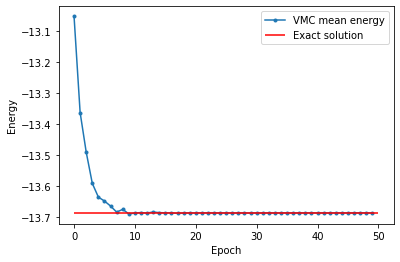

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(list(range(50)), np.real(logger.data["Energy"]["Mean"]), ".-", label="VMC mean energy")
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.hlines(exact, 0, 50, label="Exact solution", color="red")
plt.legend()
plt.show()

#### Neural Network Quantum States

Еще более интересный подход к выбору _trial wave function_ -- это использование в качестве $\Psi(X)$ нейронной сети {cite}`carleo2017nqs`. Уже немного [касались этой темы](../../qmlkinds/ru/qmlkinds.html#nqs), когда речь шла о видах квантового машинного обучения. Хороший вариант, это использовать, например, полносвязную сеть -- ограниченную машину Больцмана:

```{figure} /_static/problems2qml/ru/eigenvals/NQS.png
:width: 450px
:name: NQS2
Нейронная сеть в качестве _trial wave function_ из работы {cite}`carleo2017nqs`.
```

Это также легко может быть реализовано с использованием библиотеки `NetKet`:

/home/runner/work/qmlcourse/qmlcourse/.venv/lib/python3.8/site-packages/netket/vqs/mc/mc_state/state.py:58: UserWarning: n_samples=1000 (1000 per MPI rank) does not divide n_chains=16, increased to 1008 (1008 per MPI rank)
  warnings.warn(


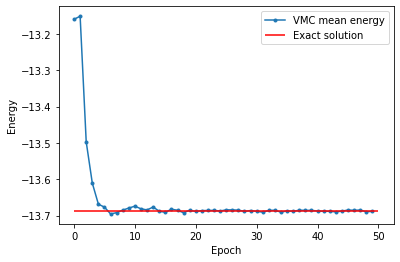

In [10]:
model = nk.models.RBM()
optimizer = nk.optimizer.Sgd(learning_rate=0.05)
sr = nk.optimizer.SR(diag_shift=0.01)
vmc = nk.driver.VMC(op, optimizer, sampler, model, n_samples=1000, preconditioner=sr)

logger = nk.logging.RuntimeLog()
vmc.run(50, out=logger, show_progress=False)

plt.figure(figsize=(6, 4))
plt.plot(list(range(50)), np.real(logger.data["Energy"]["Mean"]), ".-", label="VMC mean energy")
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.hlines(exact, 0, 50, label="Exact solution", color="red")
plt.legend()
plt.show()

Преимущества использования нейронной сети трудно показать на таком небольшом примере с моделью Изинга и 10-ю спинами, но они полностью раскрываются, если нужно анализировать более сложные модели.

```{note}
Это интересно, но при помощи библиотеки `NetKet` можно по сути решать проблемы комбинаторной оптимизации {cite}`sinchenko2019deep` с помощью методов _deep learning_.
```

### Проблемы с VMC

К сожалению, у метода **VMC** есть свои проблемы. Это относительно плохая масштабируемость -- при росте размерности проблемы для того, чтобы подобрать реально хорошую аппроксимацию потребуется все больше итераций и семплов на каждой из них. Также у **VMC** есть ряд фундаментальных проблем, например, так называемая _sign problem_ {cite}`loh1990sign`.

## Заключение

В этой лекции рассмотрены известные подходы к решению задачи о минимальном собственном значении на классическом компьютере. Как увидели, все эти методы не могут быть масштабированы на реально большие операторы. Так что для решения этих проблем действительно нужен квантовый компьютер.